In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
pd.set_option('display.max_rows', None)

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# According to EDA, these were the columns important for price prediction
price_prediction_columns = [
    'sector',
    'num_bedrooms',
    'num_bathrooms',
    'num_balconies',
    'age_group', 
    'super_built_up_area', 
    'built_up_area', 
    'carpet_area',
    'floor_number',
    'servant_room',
    'pooja_room',
    'store_room',
    'furnished',
    'Centrally Air Conditioned',
    'False Ceiling Lighting',
    'Intercom Facility',
    'Private Garden / Terrace',
    'Separate entry for servant room',
    'Spacious Interiors'
]

In [144]:
data = pd.read_csv("cleaned_data_v2.csv")

# Getting rid of columns which won't be available while prediction(to avoid data leakage) or columns whose cleaner version is already available

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2860 entries, 0 to 2859
Data columns (total 84 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            2860 non-null   float64
 1   facing                           2054 non-null   object 
 2   property_id                      2860 non-null   object 
 3   sector                           2860 non-null   object 
 4   society_name                     2860 non-null   object 
 5   society_stars                    1646 non-null   float64
 6   num_bedrooms                     2860 non-null   int64  
 7   num_bathrooms                    2860 non-null   float64
 8   num_balconies                    2860 non-null   float64
 9   age_group                        2860 non-null   object 
 10  super_built_up_area              2860 non-null   float64
 11  built_up_area                    2860 non-null   float64
 12  carpet_area         

In [146]:
columns_to_drop = [
    'property_id', # user won't give as input
    'facing', # has NaN value, also EDA said not at all important for price prediction
    'nearby_locations', # NLP required currently can't do anything
    'description_keywords', # NLP required, currently can't do anything
    'society_name', # user won't give as input
    'society_stars', # user won't give as input
    'price_per_sqft', # user won't give as input
    'amenities_rating', # user won't give as input
    'connectivity_rating', # user won't give as input
    'construction_rating', # user won't give as input
    'environment_rating', # user won't give as input
    'green area_rating', # user won't give as input
    'lifestyle_rating', # user won't give as input
    'management_rating', # user won't give as input
    'safety_rating', # user won't give as input
    'total_floors' # user won't tell
]

In [147]:
data.drop(columns=columns_to_drop, inplace=True)

In [148]:
data.columns

Index(['price', 'sector', 'num_bedrooms', 'num_bathrooms', 'num_balconies',
       'age_group', 'super_built_up_area', 'built_up_area', 'carpet_area',
       'floor_number', 'servant_room', 'study_room', 'pooja_room',
       'other_additional_room', 'store_room', 'ac', 'bed', 'chimney',
       'curtains', 'dining', 'exhaust', 'fan', 'fridge', 'geyser', 'light',
       'microwave', 'modular', 'sofa', 'stove', 'tv', 'wardrobe', 'washing',
       'water', 'Airy Rooms', 'Bank Attached Property',
       'Centrally Air Conditioned', 'Club house / Community Center',
       'False Ceiling Lighting', 'Feng Shui / Vaastu Compliant',
       'Fitness Centre / GYM', 'High Ceiling Height', 'Intercom Facility',
       'Internet/wi-fi connectivity', 'Lift(s)', 'Low Density Society',
       'Maintenance Staff', 'Natural Light', 'No open drainage around', 'Park',
       'Piped-gas', 'Power Back-up', 'Private Garden / Terrace',
       'Rain Water Harvesting', 'Recently Renovated', 'Security / Fire Alarm'

# Tree Based Feature Selection(Ordinal Encoding would work well)

In [149]:
import copy

original_data = copy.deepcopy(data) # storing a copy of data

In [31]:
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = data.select_dtypes(include=['object']).columns
for column_name in categorical_columns:
    data[column_name] = OrdinalEncoder().fit_transform(data[[column_name]])

In [32]:
data.sample(5)

,price,sector,num_bedrooms,num_bathrooms,num_balconies,age_group,super_built_up_area,built_up_area,carpet_area,floor_number,...,Spacious Interiors,Swimming Pool,Visitor Parking,Waste Disposal,Water Storage,Water purifier,Water softening plant,total_num_rooms,furnished,floor_category
239,0.90,81.0,3,3.0,3.0,4.0,1872.869333,1622.000000,1438.747516,3.0,...,0,1,1,0,0,0,0,10.0,0,1.0
1973,0.60,59.0,3,2.0,1.0,2.0,1000.000000,950.000000,900.000000,3.0,...,0,0,0,0,0,0,0,6.0,0,1.0
830,3.00,55.0,4,4.0,3.0,1.0,2383.000000,2200.000000,2000.000000,5.0,...,0,1,1,1,1,1,1,13.0,1,1.0
2538,0.89,88.0,2,2.0,2.0,4.0,1396.425000,1214.480076,1075.000000,3.0,...,0,0,0,0,0,0,0,7.0,1,1.0
1863,2.78,25.0,3,3.0,3.0,2.0,2690.000000,2599.000000,2450.000000,3.0,...,1,1,1,1,1,1,1,11.0,0,1.0


In [33]:
X = data.drop(columns=['price'])
y = data['price']

# Removing Duplicate Columns

In [34]:
def get_duplicate_columns(data):
    
    duplicate_columns = {}
    seen_columns = {}

    for column in data.columns:
        current_column = data[column]

        # Converting column data to bytes
        try:
            current_column_hash = current_column.values.tobytes()
        except AttributeError:
            current_column_hash = current_column.to_string().encode()

        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]] = [column]
        else:
            seen_columns[current_column_hash] = column

    return duplicate_columns

In [35]:
get_duplicate_columns(X)

{}

There isn't any duplicate columns

# Variance Threshold

In [36]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.01)
vt.fit(X)

VarianceThreshold(threshold=0.01)

In [37]:
sum(vt.get_support())

67

All the columns have variance greater than threshold

# Pearson Correlation Coefficient

**Note: All these shows the extent to which these columns are 'linearly' related to output, and not overall relation.**

- super_built_up_area > built_up_area > carpet_area, so can keep only super_built_up_area
- num_bathrooms(0.59) > total_num_rooms(0.58) > num_bedrooms(0.50+) > servant_room(0.40+) > num_balconies(0.30+)
- ac(0.4) > geyser(0.31) > wardrobe(0.25) > fan(0.25) > chimney(0.24) > stove(0.23) > light(0.22) > furnished(0.21)
- floor_number(0.21) >>> floor_category(~0)
- Separate entry for servant room(0.23) >  Intercom Facility(0.19) > Swimming Pool(0.17) > False Ceiling Lighting(0.16) > Piped-gas(0.15) > Spacious Interiors(0.15) > High Ceiling Height(0.15) > Centrally Air Conditioned(0.15) > Club house / Community Center(0.15) > Low Density Society(0.15) > No open drainage around(0.14) > Private Garden / Terrace(0.14)

<Axes: >

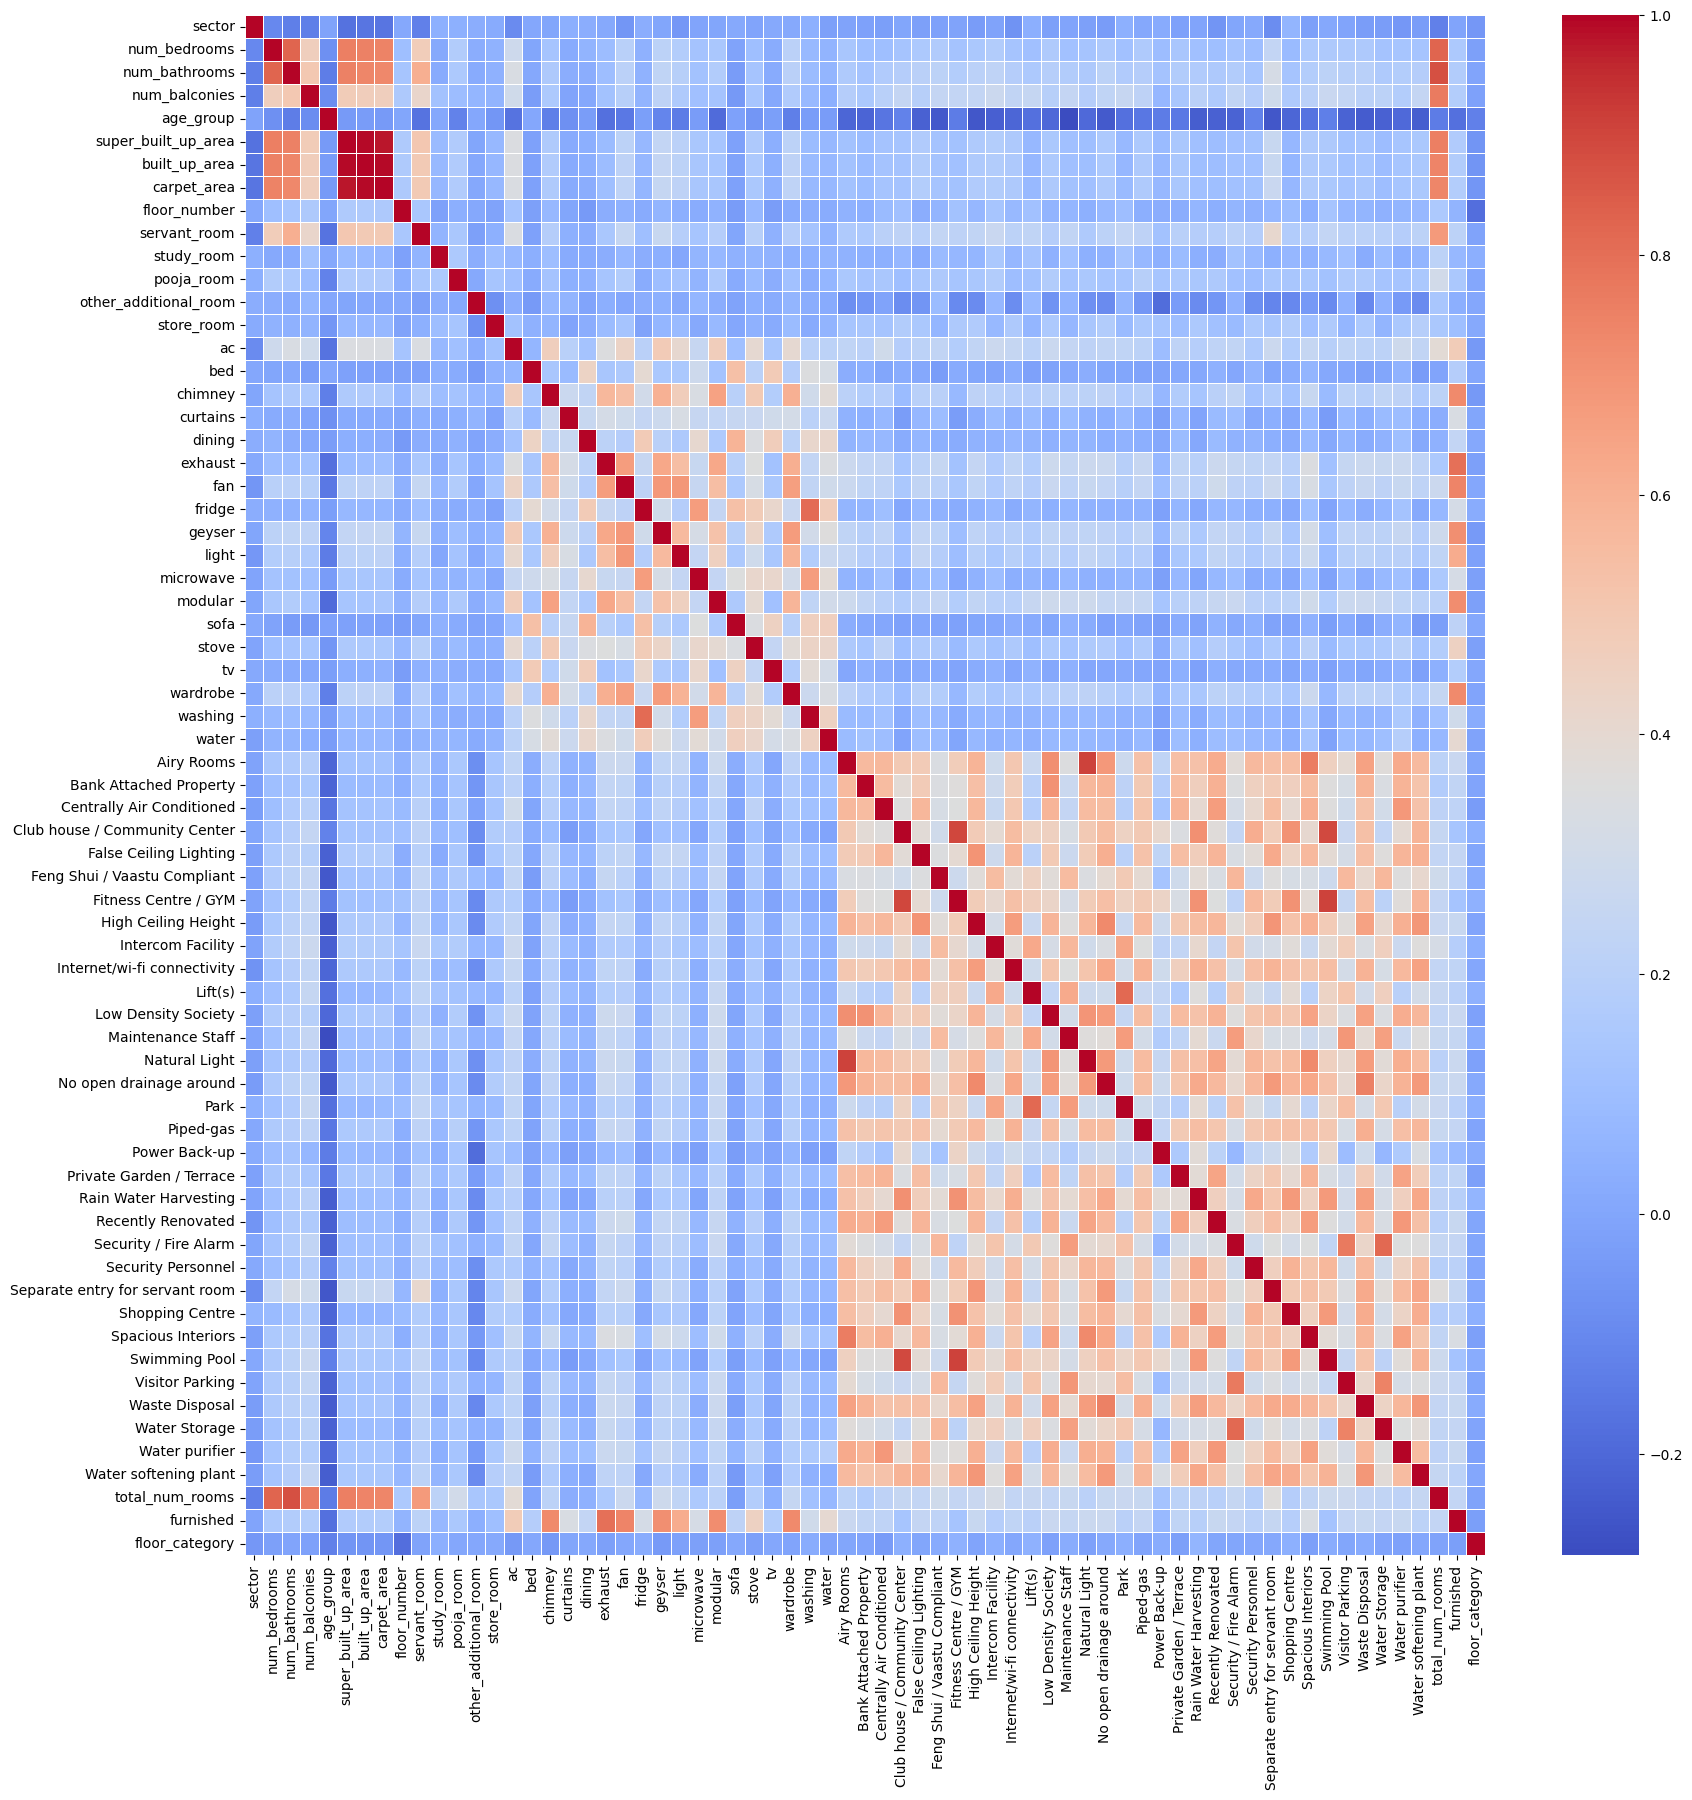

In [38]:
plt.figure(figsize=(20, 20))

sns.heatmap(X.corr(), cmap='coolwarm', linewidths=.5)

- super_built_up_area, built_up_area and carpet_area have a strong positive correlation

In [39]:
data.corr()['num_bedrooms']['num_bathrooms']

0.8289840494464

In [40]:
data.corr()['super_built_up_area']['num_bedrooms']

0.7571020727848129

In [41]:
# So the minimum correlation present in data(dark violet colored heatmap) is nearly -0.21.
data.corr()['age_group']['Airy Rooms']

-0.20518573344308078

In [42]:
data.corr()['washing']['fridge']

0.8093381046687889

In [43]:
corr_coef_price = data.corr()['price'].reset_index().rename(columns={'index': 'feature', 'price': 'correlation_coefficient'})

In [44]:
correlation_data = corr_coef_price.set_index('feature').squeeze().drop('price')

In [45]:
correlation_data

feature
sector                            -0.166491
num_bedrooms                       0.559677
num_bathrooms                      0.597765
num_balconies                      0.354935
age_group                          0.030605
super_built_up_area                0.769239
built_up_area                      0.767020
carpet_area                        0.752244
floor_number                       0.213710
servant_room                       0.439156
study_room                         0.071871
pooja_room                         0.124570
other_additional_room             -0.009828
store_room                         0.063217
ac                                 0.391944
bed                               -0.016432
chimney                            0.242581
curtains                           0.040038
dining                             0.029831
exhaust                            0.126827
fan                                0.246718
fridge                             0.137384
geyser                  

In [46]:
corr_coef_price.sort_values('correlation_coefficient', ascending=False).T.to_dict()

{0: {'feature': 'price', 'correlation_coefficient': 1.0},
 6: {'feature': 'super_built_up_area',
  'correlation_coefficient': 0.7692385076257872},
 7: {'feature': 'built_up_area',
  'correlation_coefficient': 0.7670204865628875},
 8: {'feature': 'carpet_area', 'correlation_coefficient': 0.7522444426409305},
 3: {'feature': 'num_bathrooms',
  'correlation_coefficient': 0.5977651640759484},
 65: {'feature': 'total_num_rooms',
  'correlation_coefficient': 0.5845095941460774},
 2: {'feature': 'num_bedrooms', 'correlation_coefficient': 0.5596765609524958},
 10: {'feature': 'servant_room',
  'correlation_coefficient': 0.4391557377386093},
 15: {'feature': 'ac', 'correlation_coefficient': 0.39194350829724006},
 4: {'feature': 'num_balconies',
  'correlation_coefficient': 0.35493545832756196},
 23: {'feature': 'geyser', 'correlation_coefficient': 0.31043101323017736},
 30: {'feature': 'wardrobe', 'correlation_coefficient': 0.24785566088119781},
 21: {'feature': 'fan', 'correlation_coefficient'

# Mutual Information

- Unlike correlation coefficient, it can even capture non linear relationship.
- super_built_up_area(0.89) >> built_up_area/carpet(0.72).
- sector(0.61) is the next most important column.
- total_num_rooms(0.43) > num_bathrooms(0.39) > num_bedrooms(0.32) > num_balconies(0.21) 
- ac(0.17) > wardrobe(0.12) > fan(0.11) > geyser(0.11)
- servant_room(0.16) > > pooja_room(0.03) > study_room(0.02), store_room and other_additional_room are 0.
- Swimming Pool(0.07) > Separate entry for servant room(0.07) > Club house / Community Center(0.06) > Water softening plant(0.06) > Water softening plant(0.05) > Water purifier(0.05) > Fitness Centre / GYM(0.05) > Feng Shui / Vaastu Compliant(0.05) > High Ceiling Height(0.05) > Maintenance Staff(0.05).
- floor_number(0.06) > floor_category(0.03) 

In [47]:
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X, y)
mutual_information_values = {}

for feature_name, mutual_info_value in zip(X.columns, mutual_info):
    mutual_information_values[feature_name] = mutual_info_value

In [48]:
mutual_information_values = dict(sorted(mutual_information_values.items(), key=lambda item: item[1], reverse=True))

In [49]:
mutual_information_values

{'super_built_up_area': 0.8832200741596052,
 'built_up_area': 0.7416264281226415,
 'carpet_area': 0.7104943019826475,
 'sector': 0.5963286464324633,
 'total_num_rooms': 0.41326094220467136,
 'num_bathrooms': 0.39105084061208695,
 'num_bedrooms': 0.33161411065438084,
 'num_balconies': 0.20140558636437866,
 'ac': 0.19098415540567304,
 'servant_room': 0.16451643926263904,
 'geyser': 0.13156561792321853,
 'wardrobe': 0.11208220177865513,
 'fan': 0.10587796963849527,
 'Separate entry for servant room': 0.07344682436322669,
 'floor_number': 0.06589781126025329,
 'Swimming Pool': 0.062339549798119176,
 'Intercom Facility': 0.0615710765195816,
 'Feng Shui / Vaastu Compliant': 0.05907288824741119,
 'Water softening plant': 0.058034847966148106,
 'Club house / Community Center': 0.05737157260857595,
 'Low Density Society': 0.05551699349032546,
 'light': 0.055392227686690276,
 'High Ceiling Height': 0.04810709975668104,
 'floor_category': 0.04664465177935462,
 'Recently Renovated': 0.045009528244

In [50]:
mutual_info_data = pd.Series(mutual_information_values)
mutual_info_data

super_built_up_area                0.883220
built_up_area                      0.741626
carpet_area                        0.710494
sector                             0.596329
total_num_rooms                    0.413261
num_bathrooms                      0.391051
num_bedrooms                       0.331614
num_balconies                      0.201406
ac                                 0.190984
servant_room                       0.164516
geyser                             0.131566
wardrobe                           0.112082
fan                                0.105878
Separate entry for servant room    0.073447
floor_number                       0.065898
Swimming Pool                      0.062340
Intercom Facility                  0.061571
Feng Shui / Vaastu Compliant       0.059073
Water softening plant              0.058035
Club house / Community Center      0.057372
Low Density Society                0.055517
light                              0.055392
High Ceiling Height             

# Sequential Forward Selection

- Clearly from above, we can see that very less features are important for price prediction, so we choose forward and not backward.
- 'sector', 'num_balconies', 'super_built_up_area', 'servant_room', 'pooja_room', 'store_room', 'bed', 'Bank Attached Property', 'Centrally Air Conditioned', 'Lift(s)', 'Low Density Society', 'Natural Light', 'Private Garden / Terrace', 'Rain Water Harvesting', 'Spacious Interiors' are the 15 most important features according to Decision Tree.

In [51]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state=42)
sfs = SequentialFeatureSelector(reg, k_features=15, forward=True, floating=False, scoring='neg_mean_squared_error', cv=5)
sfs.fit(X, y)
selected_features = list(X.columns[list(sfs.k_feature_idx_)])

In [52]:
selected_features

['sector',
 'num_balconies',
 'super_built_up_area',
 'servant_room',
 'pooja_room',
 'store_room',
 'bed',
 'Bank Attached Property',
 'Centrally Air Conditioned',
 'Lift(s)',
 'Low Density Society',
 'Natural Light',
 'Private Garden / Terrace',
 'Rain Water Harvesting',
 'Spacious Interiors']

# Random Forest Feature Importance

- super_built_up_area(0.47) >> sector(0.13), rest are quite low.

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

In [54]:
random_forest_data = feature_importance_rf.set_index('feature').squeeze()

In [55]:
random_forest_data

feature
super_built_up_area                0.472492
built_up_area                      0.189758
sector                             0.134084
carpet_area                        0.022718
floor_number                       0.020960
geyser                             0.016957
num_bathrooms                      0.015731
total_num_rooms                    0.010793
light                              0.008558
num_balconies                      0.008475
ac                                 0.007950
age_group                          0.007406
num_bedrooms                       0.005618
fan                                0.005370
wardrobe                           0.004924
servant_room                       0.004041
floor_category                     0.003183
microwave                          0.003053
Feng Shui / Vaastu Compliant       0.002796
Park                               0.002336
Security / Fire Alarm              0.002295
curtains                           0.002267
tv                      

# Gradient Boosting Feature importances

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X, y)

feature_importance_gb = pd.DataFrame({
    'feature': X.columns,
    'gb_importance': gb.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

In [57]:
gradient_boosting_data = feature_importance_gb.set_index('feature').squeeze()

In [58]:
gradient_boosting_data

feature
super_built_up_area                0.487095
built_up_area                      0.200597
sector                             0.167793
num_bathrooms                      0.033454
ac                                 0.017912
geyser                             0.013198
carpet_area                        0.012907
floor_number                       0.012085
servant_room                       0.005904
Recently Renovated                 0.004403
num_balconies                      0.003781
total_num_rooms                    0.003578
age_group                          0.003460
light                              0.003319
microwave                          0.003200
tv                                 0.002686
Water Storage                      0.002600
Swimming Pool                      0.002462
floor_category                     0.002359
Security Personnel                 0.001914
curtains                           0.001739
chimney                            0.001426
bed                     

# Permutation Importance

In [59]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
perm_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

In [60]:
permutation_importance_data = perm_feature_importance.set_index('feature').squeeze()

In [61]:
permutation_importance_data

feature
super_built_up_area                0.589144
sector                             0.278015
floor_number                       0.013902
geyser                             0.011257
servant_room                       0.006599
num_balconies                      0.006239
age_group                          0.006015
microwave                          0.005369
total_num_rooms                    0.004550
Swimming Pool                      0.003535
Security / Fire Alarm              0.003532
num_bathrooms                      0.003036
study_room                         0.002873
fan                                0.002635
num_bedrooms                       0.002516
floor_category                     0.002418
curtains                           0.002293
Visitor Parking                    0.001720
Fitness Centre / GYM               0.001665
Security Personnel                 0.001658
Feng Shui / Vaastu Compliant       0.001490
light                              0.001451
ac                      

# Recursive Feature Elimination

In [62]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X.shape[1], step=1)
selector_label = selector_label.fit(X, y)

# Get the selected features based on RFE
selected_features = X.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
rfe = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

In [63]:
recursive_feature_elimination_data = rfe.set_index('feature').squeeze()

In [64]:
recursive_feature_elimination_data

feature
super_built_up_area                0.489849
built_up_area                      0.168992
sector                             0.133525
carpet_area                        0.022322
floor_number                       0.022172
geyser                             0.018598
num_bathrooms                      0.017206
total_num_rooms                    0.010168
age_group                          0.008432
light                              0.008368
num_balconies                      0.007094
ac                                 0.006951
num_bedrooms                       0.005195
fan                                0.005097
wardrobe                           0.004798
servant_room                       0.004095
microwave                          0.003844
Security / Fire Alarm              0.003416
tv                                 0.003257
Feng Shui / Vaastu Compliant       0.002748
floor_category                     0.002629
study_room                         0.002214
Security Personnel      

# SHAP

In [65]:
import shap

# Compute SHAP values using the trained Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)
shap_score = pd.DataFrame({
    'feature': X.columns,
    'SHAP_score': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_score', ascending=False)

In [66]:
shap_data = shap_score.set_index('feature').squeeze()

In [67]:
overall_ordinal_encoding_importance = correlation_data.apply(abs) + mutual_info_data.apply(abs) + random_forest_data.apply(abs) + gradient_boosting_data.apply(abs) + permutation_importance_data.apply(abs) + recursive_feature_elimination_data.apply(abs) + shap_data.apply(abs)

In [68]:
overall_ordinal_encoding_importance.sort_values(ascending=False)

super_built_up_area                4.230647
built_up_area                      2.235766
sector                             1.769394
carpet_area                        1.558096
num_bathrooms                      1.092870
total_num_rooms                    1.041292
num_bedrooms                       0.915214
ac                                 0.640467
servant_room                       0.637620
num_balconies                      0.595345
geyser                             0.545310
floor_number                       0.389797
wardrobe                           0.375646
fan                                0.371364
Separate entry for servant room    0.306117
light                              0.305527
chimney                            0.294039
stove                              0.270665
Intercom Facility                  0.259771
furnished                          0.258874
microwave                          0.256923
Swimming Pool                      0.241783
modular                         

# Encoding wrt Linear Models(One Hot Encoding)

In [69]:
data = copy.deepcopy(original_data)

In [70]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = data.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['sector', 'age_group', 'floor_category'], dtype='object')


So, all of them can be one hot encoded, as all are nominal features

In [153]:
for column_name in categorical_columns:
    one_hot_encoded = pd.get_dummies(data[column_name], prefix=column_name, drop_first=True)
    
    data = data.drop(column_name, axis=1)

    data = pd.concat([data, one_hot_encoded], axis=1)

In [154]:
X = data.drop('price', axis=1)
y = data['price']

In [73]:
data.columns

Index(['price', 'num_bedrooms', 'num_bathrooms', 'num_balconies',
       'super_built_up_area', 'built_up_area', 'carpet_area', 'floor_number',
       'servant_room', 'study_room',
       ...
       'sector_sector 95', 'sector_sector 99', 'sector_shanti nagar',
       'sector_sohna road', 'age_group_Moderately Old Flat',
       'age_group_New Flat', 'age_group_Old Flat',
       'age_group_Under Construction', 'floor_category_Low rise',
       'floor_category_Mid rise'],
      dtype='object', length=175)

In [74]:
# dropping too high correlated input columns(since, inference would not be good due to multicollinearity)
def get_highly_correlated_columns(X, correlation_threshold=0.9):
    correlation_pairs = []

    for i in range(len(X.columns)):
        for j in range(i + 1, len(X.columns)):
            col1 = X.columns[i]
            col2 = X.columns[j]

            # Calculate the correlation between the two columns
            correlation = X[col1].corr(X[col2])

            # Check if the correlation is greater than the threshold
            if abs(correlation) > correlation_threshold:
                correlation_pairs.append((col1, col2, correlation))
    return correlation_pairs

In [75]:
correlation_pairs = get_highly_correlated_columns(X)

In [76]:
correlation_pairs

[('super_built_up_area', 'built_up_area', 0.9905769957809325),
 ('super_built_up_area', 'carpet_area', 0.9793763721928429),
 ('built_up_area', 'carpet_area', 0.9901734404891087),
 ('Airy Rooms', 'Natural Light', 0.9072250607003409),
 ('Fitness Centre / GYM', 'Swimming Pool', 0.9047787834933723)]

In [77]:
 # dropping the columns from the pairs which had lower scores in tree based Feature selection
X.drop(columns=['built_up_area', 'carpet_area', 'Natural Light', 'Fitness Centre / GYM'], inplace=True)

# Lasso

- Whether your house is in the costly sectors/not varies price a lot.
- Hence linear model suggests super_built_up_area, sector, ac, num_bathrooms, floor_number.

In [78]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y)

# Extract coefficients
lasso = pd.DataFrame({
    'feature': X.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

In [79]:
lasso_scores = lasso.set_index('feature').squeeze().sort_values(ascending=False)

In [80]:
lasso_scores

feature
super_built_up_area                0.789324
sector_sector 65                   0.217457
sector_sector 54                   0.201092
sector_sector 53                   0.198620
sector_sector 62                   0.182267
sector_sector 43                   0.141107
sector_sector 63                   0.125005
sector_sector 48                   0.106867
sector_sector 50                   0.095920
sector_sector 66                   0.095710
sector_sector 59                   0.091880
sector_sector 72                   0.090982
sector_sector 28                   0.090398
ac                                 0.081568
sector_sector 67                   0.081466
num_bathrooms                      0.079149
floor_number                       0.078500
sector_sector 61                   0.073428
sector_sector 22                   0.067850
sector_sector 112                  0.061722
sector_sector 60                   0.061288
sector_sector 58                   0.060713
sector_sector 24        

# Linear Regression Weights

In [81]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y)

# Extract coefficients
linear_regression_scores = pd.DataFrame({
    'feature': X.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

In [82]:
linear_regression_scores = linear_regression_scores.set_index('feature').squeeze().sort_values(ascending=False)

In [83]:
linear_regression_scores # doesn't seem trustable

feature
total_num_rooms                    7.164476e+11
super_built_up_area                7.710266e-01
sector_sector 53                   1.783290e-01
sector_sector 54                   1.750536e-01
sector_sector 62                   1.558456e-01
sector_sector 65                   1.404037e-01
sector_sector 43                   1.186523e-01
sector_sector 63                   8.482742e-02
ac                                 7.819748e-02
fridge                             7.298279e-02
sector_sector 59                   7.232094e-02
sector_sector 48                   7.199669e-02
sector_sector 50                   6.613803e-02
sector_sector 28                   6.295252e-02
Centrally Air Conditioned          5.986214e-02
sector_sector 24                   5.383682e-02
sector_sector 66                   5.354500e-02
sector_sector 72                   5.308914e-02
microwave                          4.792786e-02
sector_sector 58                   4.739380e-02
Shopping Centre                 

In [84]:
overall_ordinal_encoding_importance.sort_values(ascending=False)

super_built_up_area                4.230647
built_up_area                      2.235766
sector                             1.769394
carpet_area                        1.558096
num_bathrooms                      1.092870
total_num_rooms                    1.041292
num_bedrooms                       0.915214
ac                                 0.640467
servant_room                       0.637620
num_balconies                      0.595345
geyser                             0.545310
floor_number                       0.389797
wardrobe                           0.375646
fan                                0.371364
Separate entry for servant room    0.306117
light                              0.305527
chimney                            0.294039
stove                              0.270665
Intercom Facility                  0.259771
furnished                          0.258874
microwave                          0.256923
Swimming Pool                      0.241783
modular                         

# Final Decision

In [103]:
important_columns = [
    'sector',
    'num_bedrooms',
    'num_bathrooms',
    'num_balconies',
    'age_group', 
    'super_built_up_area', 
    'floor_number',
    'servant_room',
    'furnished',
    'Centrally Air Conditioned',
    'False Ceiling Lighting',
    'Intercom Facility',
    'Private Garden / Terrace',
    'Separate entry for servant room',
    'Spacious Interiors',
    'Swimming Pool',
    'Club house / Community Center',
    'Piped-gas',
    'ac',
    'geyser',
    'fan',
    'wardrobe',
    'light',
    'Low Density Society',
    'total_num_rooms',
]

# Initial Model

In [104]:
price_prediction_data = original_data[important_columns]

,sector,num_bedrooms,num_bathrooms,num_balconies,age_group,super_built_up_area,floor_number,servant_room,furnished,Centrally Air Conditioned,...,Swimming Pool,Club house / Community Center,Piped-gas,ac,geyser,fan,wardrobe,light,Low Density Society,total_num_rooms
1621,sector 95,3,3.0,2.0,Moderately New Flat,1965.00000,4.0,0,0,0,...,0,0,0,0,0,0,1,0,0,9.0
743,sector 112,3,5.0,4.0,Moderately New Flat,2802.00000,22.0,1,1,0,...,0,0,0,5,4,0,0,0,0,13.0
1503,sector 85,4,4.0,3.0,Moderately New Flat,2812.00000,7.0,1,0,0,...,0,0,0,6,0,0,0,0,0,14.0
2744,sector 37,3,3.0,3.0,Moderately New Flat,1920.00000,7.0,0,1,0,...,1,1,0,2,2,4,4,10,0,9.0
1307,sector 95,3,2.0,1.0,Moderately New Flat,836.71188,2.0,0,1,0,...,0,0,0,0,1,5,0,8,0,7.0


In [105]:
X = price_prediction_data
y = original_data['price']

In [106]:
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = X.select_dtypes(include=['object']).columns
for column_name in categorical_columns:
    X[column_name] = OrdinalEncoder().fit_transform(X[[column_name]])

In [107]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

scores = cross_val_score(gb, X, y, cv=5, scoring='r2')

In [108]:
scores.mean()

0.758560293382874

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_regressor.fit(X_train, y_train.ravel())
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_regressor.fit(X_train, y_train.ravel())

# Make predictions on the test set
y_pred = gb_regressor.predict(X_test)

# Calculate Mean Absolute Error on the test set
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.3709284419541382


In [114]:
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_regressor = XGBRegressor()

# Train the model on the training set
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.31323354219744254


In [115]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7496725029789144

In [129]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp
import numpy as np

price_prediction_data = original_data[important_columns]
X = price_prediction_data
y = original_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the objective function to minimize (Mean Squared Error)
def objective(params):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree']
    )

    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Define the search space for hyperparameters
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.loguniform('gamma', -5, 0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

# Use Hyperopt to find the best hyperparameters
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, rstate=np.random.default_rng(42))

# Print the best hyperparameters found
print("Best Hyperparameters:")
print(best)


100%|███████████████████████████████████████████████| 50/50 [01:20<00:00,  1.60s/trial, best loss: 0.35541783325290816]
Best Hyperparameters:
{'colsample_bytree': 0.503206723596417, 'gamma': 0.019010673210746596, 'learning_rate': 0.01860551689616581, 'max_depth': 15.0, 'n_estimators': 452.0, 'subsample': 0.817852356865858}


In [130]:
best_params = {
    'colsample_bytree': 0.503206723596417, 
    'gamma': 0.019010673210746596, 
    'learning_rate': 0.01860551689616581, 
    'max_depth': 15.0, 
    'n_estimators': 452.0, 
    'subsample': 0.817852356865858
}

# Create an instance of XGBRegressor with the best hyperparameters
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    subsample=best_params['subsample'],
    gamma=best_params['gamma'],
    colsample_bytree=best_params['colsample_bytree']
)

# Train the model on the training set
xgb_regressor.fit(X_train, y_train.ravel())

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculate Mean Absolute Error on the test set
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.2858711842609035


In [131]:
r2_score(y_test, y_pred)

0.7925914621242851